In [17]:
import gurobipy as gb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
from scipy.spatial.distance import euclidean
from scipy.stats import truncnorm
import pickle
import os
from source import *

path = os.getcwd()

# Global variables

In [18]:
''' Non-linear charging function parameters '''
energy_bps = [0,212.5,237.5,250] # Energy level (miles) breakpoints in the piecewise linear function
charging_rates = [260.1,118.575,39.525] # Charging rates (miles/hour) for every piece in the charging function
full_rch_time = 1.344086022 # Time that it would take for a vehicle to recharge until full range (250 miles) with an empty battery


# Functions

In [19]:
def nl_charging_function(soc):

    p = [i for i in range(3) if energy_bps[i]<=soc and soc<=energy_bps[i+1]][0]
    return full_rch_time - sum((min(soc,energy_bps[pp+1])-energy_bps[pp])/charging_rates[pp] for pp in range(p+1))

def dump_parameters(sc,mu,sigma,K,r,S_k,K_s,tp,p,a,t):
    
    file = open(path+f"/Sensitivity/Data/K/K_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(K,file); file.close()

    file = open(path+f"/Sensitivity/Data/r/r_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(r,file); file.close()

    file = open(path + f'/Sensitivity/Data/S_k/Sk_mu{mu}_sigma{sigma}_sc{sc}', 'wb')
    pickle.dump(S_k, file); file.close()

    file = open(path + f'/Sensitivity/Data/K_s/Ks_mu{mu}_sigma{sigma}_sc{sc}', 'wb')
    pickle.dump(K_s, file); file.close()

    file = open(path + f"/Sensitivity/Data/tp/tp_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(tp,file); file.close()

    file = open(path + f'/Sensitivity/Data/p/p_mu{mu}_sigma{sigma}_{sc}', 'wb')
    pickle.dump(p, file); file.close()

    file = open(path + f'/Sensitivity/Data/a t/at_mu{mu}_sigma{sigma}_{sc}', 'wb')
    pickle.dump((a,t), file); file.close()


def generate_stochastic_parameters(mu, sigma, distances, S):

    ''' Import vehicles dataframe'''
    vehicles = pd.read_csv(path+"/Data/Definite Vehicles.csv",index_col=[0])
    file = open(path+"/Data/closest_10_stations","rb")
    closest_10 = pickle.load(file); file.close()

    ''' Demand parameters for truncated normal distribution '''
    loc, scale, min_v, max_v = mu, sigma, 20, 250
    aa, b = (min_v - loc) / scale, (max_v - loc) / scale

    ''' Import other parameters '''
    file = open(path+"/Data/Global/dem_distribution","rb")
    dem_distribution = pickle.load(file); file.close()
    dem_time_steps = list(range(len(dem_distribution)))

    ''' Scenario generation '''
    flag = True
    ii = -1
    while flag:
        ii += 1
        flag = False
        ranges, realized = dict(), dict()

        for i in vehicles.index:
            feas = False
            rr = truncnorm.rvs(a = aa, b = b, loc = loc, scale = scale, size = 1)
            ranges[i] = rr[0]

            prob = np.exp(-0.012**2*(rr-20)**2)
            realization = random.choice([True,False], p = [prob[0], 1-prob[0]])
            realized[i] = realization

            if realization == True:
                for st in S:
                    if distances[st,i] <= rr:
                        feas = True; break

                if not feas:
                    flag = True
                    print(f'\tAttempt n. {ii} failed at vehicle {i}')
                    break
    
    K = [k for k in vehicles.index if realized[k]]
    r = {k:ranges[k] for k in K}
    tp = {k:random.choice(dem_time_steps,p=dem_distribution) for k in K}

    ''' Compute other parameters '''
    S_k = {k:[s for s in closest_10[k] if s in S and distances[s,k]<=r[k]] for k in K}
    K_s = {s:[k for k in K if s in S_k[k]] for s in S}

    return K, r, tp, S_k, K_s

def get_optimal_solution():
    file = open(path+"/Results/Optimal/S","rb")
    S = pickle.load(file); file.close()

    file = open(path+"/Results/Optimal/n","rb")
    n = pickle.load(file); file.close()

    file = open(path+"/Results/Optimal/distances","rb")
    distances = pickle.load(file); file.close()

    return S, n, distances

def run_scenario(mu,sigma,sc):

    ''' Import station configuration, number of chargers and distance matrix '''
    S, n, distances = get_optimal_solution()

    ''' Import global parameters '''
    file = open(path+"/Data/Global/driving_speed","rb")
    driving_speed = pickle.load(file); file.close()
    
    ''' Generate stochastic parameters of scenario '''
    K, r, tp, S_k, K_s = generate_stochastic_parameters(mu,sigma,distances,S)
    
    p = {(k,s):250-(r[k]-distances[s,k]) for s in S for k in K_s[s]}
    t = {(k,s):nl_charging_function(r[k]-distances[s,k])  for s in S for k in K_s[s]}
    a = {(k,s):distances[s,k]/driving_speed+tp[k]/4 for s in S for k in K_s[s]}
    a.update({("s",s):0 for s in S}); a.update({("e",s):30 for s in S})
    t.update({("s",s):0 for s in S}); t.update({("e",s):0 for s in S})

    ''' Saves scenario parameters '''
    dump_parameters(sc,mu,sigma,K,r,S_k,K_s,tp,p,a,t)

    results = test_scenario_sensitivity(S,K,K_s,n,a,t)

    print("\n--------------------RESULTS--------------------")
    print(f"A total of {len(K)} vehicles need to be assigned")
    print(f"\tTotal assigned vehicles: {len(results['total_total'])}")
    print(f"\tTotal unassigned vehicles: {len(results['infeasible'])}")
    print(f"Achieved Service Level: {round(100*(1-len(results['infeasible'])/len(K)),2)}")

    return results


In [20]:
mu = 120; sigmas = [20,50,80]
for sc in range(100):
    for sigma in sigmas:
        results = run_scenario(mu,sigma,sc)
        file = open(path+f"/Sensitivity/Results/results_mu{mu}_sigma{sigma}_sc{sc}","wb")
        pickle.dump(results,file); file.close()

		Iteration 0:		MP obj: 2861.0	time: 0.02s
		Iteration 1:		MP obj: 3.0	time: 7.83s
		Iteration 2:		MP obj: 2.0	time: 8.02s
		Iteration 3:		MP obj: 2.0	time: 8.03s
		Iteration 4:		MP obj: 2.0	time: 8.05s
		Iteration 5:		MP obj: 2.0	time: 8.08s
		Iteration 6:		MP obj: 2.0	time: 8.11s
		Iteration 7:		MP obj: 2.0	time: 8.16s
		Iteration 8:		MP obj: 1.83	time: 8.17s
	IMP obj: 2.0	Optimality gap: 0.0

--------------------RESULTS--------------------
A total of 2861 vehicles need to be assigned
	Total assigned vehicles: 2859
	Total unassigned vehicles: 2
Achieved Service Level: 99.93
	Attempt n. 0 failed at vehicle 7527
		Iteration 0:		MP obj: 3462.0	time: 0.02s
		Iteration 1:		MP obj: 14.67	time: 14.67s
		Iteration 2:		MP obj: 2.0	time: 14.95s
		Iteration 3:		MP obj: 1.0	time: 14.97s
		Iteration 4:		MP obj: 1.0	time: 14.98s
		Iteration 5:		MP obj: 1.0	time: 15.0s
		Iteration 6:		MP obj: 1.0	time: 15.02s
		Iteration 7:		MP obj: 1.0	time: 15.03s
		Iteration 8:		MP obj: 1.0	time: 15.05s
	IMP obj

In [21]:
mu = 100; sigmas = [20,50,80]
for sc in range(100):
    for sigma in sigmas:
        results = run_scenario(mu,sigma,sc)
        file = open(path+f"/Sensitivity/Results/results_mu{mu}_sigma{sigma}_sc{sc}","wb")
        pickle.dump(results,file); file.close()

		Iteration 0:		MP obj: 4547.0	time: 0.02s
		Iteration 1:		MP obj: 46.24	time: 29.03s
		Iteration 2:		MP obj: 5.25	time: 30.0s
		Iteration 3:		MP obj: 1.3	time: 30.16s
		Iteration 4:		MP obj: 1.0	time: 30.52s
		Iteration 5:		MP obj: 1.0	time: 30.55s
		Iteration 6:		MP obj: 1.0	time: 30.58s
		Iteration 7:		MP obj: 1.0	time: 30.61s
		Iteration 8:		MP obj: 1.0	time: 30.64s
		Iteration 9:		MP obj: 1.0	time: 30.67s
		Iteration 10:		MP obj: 1.0	time: 30.69s
		Iteration 11:		MP obj: 1.0	time: 30.73s
		Iteration 12:		MP obj: 1.0	time: 30.75s
		Iteration 13:		MP obj: 1.0	time: 30.78s
		Iteration 14:		MP obj: 1.0	time: 30.81s
		Iteration 15:		MP obj: 1.0	time: 30.84s
		Iteration 16:		MP obj: 1.0	time: 30.88s
	IMP obj: 6.0	Optimality gap: 0.0

--------------------RESULTS--------------------
A total of 4547 vehicles need to be assigned
	Total assigned vehicles: 4541
	Total unassigned vehicles: 6
Achieved Service Level: 99.87
		Iteration 0:		MP obj: 4539.0	time: 0.03s
		Iteration 1:		MP obj: 53.79	

# Plots

In [28]:
mu = [100,120]
sigma = [20,50,80]

K = dict(); serv_level = dict()

for m in mu:
    for s in sigma:
        K[m,s] = list(); serv_level[m,s] = list()
        for sc in range(100):
            file = open(path+f"/Sensitivity/Results/results_mu{m}_sigma{s}_sc{sc}","rb")
            results = pickle.load(file); file.close()

            K[m,s].append(len(results["total_total"]) + len(results["infeasible"]))
            serv_level[m,s].append(1-len(results["infeasible"])/K[m,s][-1])
            

Text(0.5, 0.98, 'Sensitivity Analysis on\nInitial Available Driving Range')

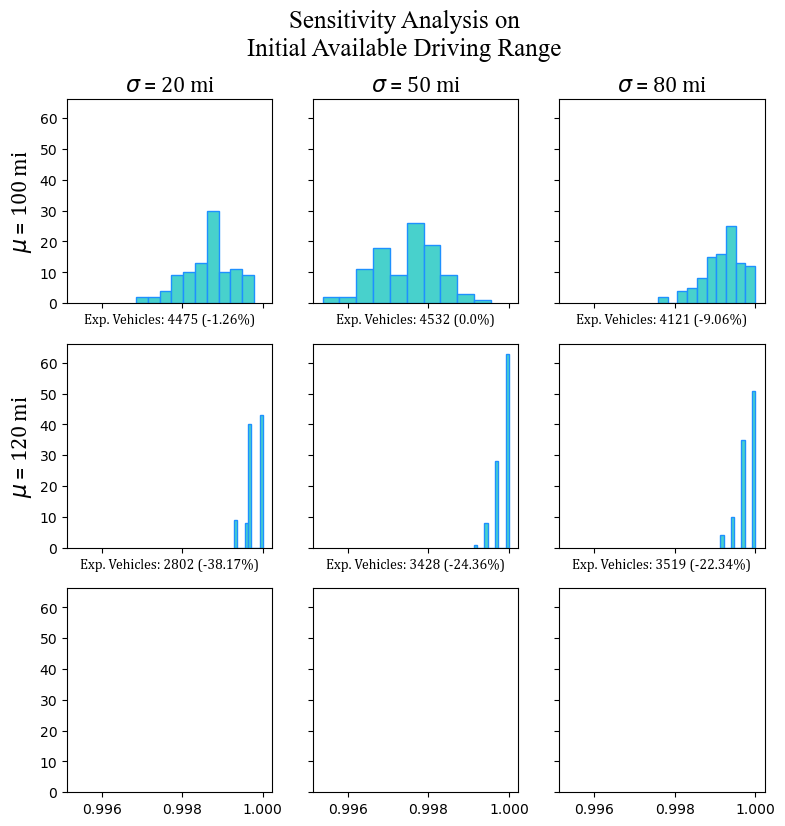

In [45]:
fig, subp = plt.subplots(figsize=(9,9),sharex=True,sharey=True,nrows=3,ncols=3)

axes = {}; i = 0; j = 0
for m in mu:
    for s in sigma:
        axes[m,s] = subp[i,j]
        if j == 2: i += 1; j = 0
        else: j += 1


base = np.mean(K[100,50])
for m in mu:
    for s in sigma:
        
        axes[m,s].hist(serv_level[m,s],edgecolor="dodgerblue",color="mediumturquoise")
        dem = np.mean(K[m,s])
        ss = f"Exp. Vehicles: {int(dem)} ({round(100*(dem/base-1),2)}%)"
        axes[m,s].set_xlabel(ss,fontsize=10,fontname="Cambria")

        if m == mu[0]: axes[m,s].set_title(r"$\sigma$" + f" = {s} mi",fontsize=16,fontname="Cambria")
        if s == sigma[0]: axes[m,s].set_ylabel(r"$\mu$" + f" = {m} mi",fontsize=16,fontname="Cambria")

fig.suptitle("Sensitivity Analysis on\nInitial Available Driving Range",fontname="Times New Roman",fontsize=18)

In [ ]:
fo